In [1]:
import sys
sys.path.append("../src")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from joint_tof_opt.compact_stat_process import NthOrderMoment, NthOrderCenteredMoment, WindowedSum
from joint_tof_opt.signal_process import CombSeparator
from joint_tof_opt.metric_process import EnergyRatioMetric, ContrastToNoiseMetric
from joint_tof_opt import compute_noise_m1, compute_noise_variance, compute_noise_window_sum

# Load the generated ToF dataset
data = np.load("../data/generated_tof_set.npz")
tof_series = data["tof_dataset"]  # Shape: (num_timepoints, num_bins)
bin_edges = data["bin_edges"]  # Shape: (num_bins + 1,)
sampling_rate = data["sampling_rate"]   # Sampling rate in Hz
fetal_f = data["fetal_f"]  # Fetal heartbeat frequency in Hz
maternal_f = data["maternal_f"]  # Maternal heartbeat frequency in Hz
time_axis = data["time_axis"]  # Time axis

# Convert to torch tensors
tof_series_tensor = torch.tensor(tof_series, dtype=torch.float32)
bin_edges_tensor = torch.tensor(bin_edges, dtype=torch.float32)
num_timepoints, num_bins = tof_series_tensor.shape

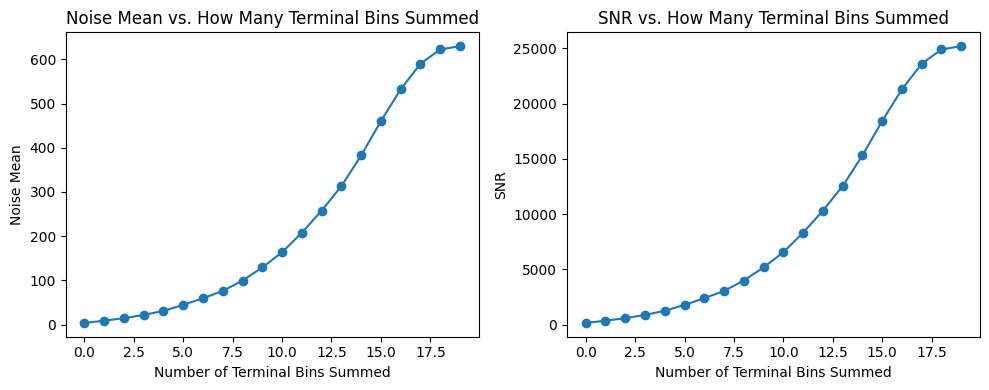

In [2]:
all_noise_window_sums = []
all_snr_window_sums = []
for i in range(num_bins):
    window = torch.zeros(num_bins, dtype=torch.float32)
    window[-i - 1:] = 1.0
    noise_window_sum = compute_noise_window_sum(tof_series_tensor, bin_edges_tensor, window)
    noise_mean = noise_window_sum.mean()
    signal = WindowedSum(tof_series_tensor, bin_edges_tensor).forward(window)
    signal_energy = torch.sum(signal ** 2)
    snr_window_sum = signal_energy / noise_window_sum
    all_noise_window_sums.append(noise_mean.item())
    all_snr_window_sums.append(snr_window_sum.mean().item())
all_noise_window_sums = np.array(all_noise_window_sums)
all_snr_window_sums = np.array(all_snr_window_sums)

plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(all_noise_window_sums, marker='o')
plt.title("Noise Mean vs. How Many Terminal Bins Summed")
plt.xlabel("Number of Terminal Bins Summed")
plt.ylabel("Noise Mean")
plt.subplot(1, 2, 2)
plt.plot(all_snr_window_sums, marker='o')
plt.title("SNR vs. How Many Terminal Bins Summed")
plt.xlabel("Number of Terminal Bins Summed")
plt.ylabel("SNR")
plt.tight_layout()
plt.show()

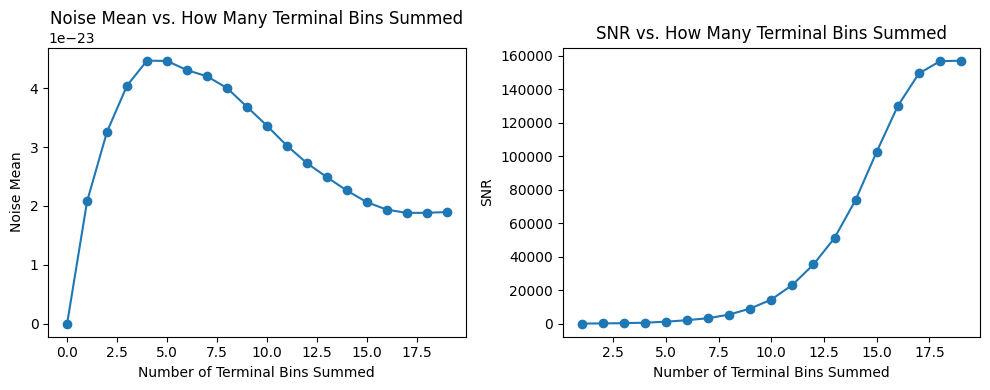

In [3]:
all_noise_m1 = []
all_snr_m1 = []
for i in range(num_bins):
    window = torch.zeros(num_bins)
    window[-i - 1:] = 1.0
    m1_noise = compute_noise_m1(tof_series_tensor, bin_edges_tensor, window)
    all_noise_m1.append(m1_noise.mean().item())
    signal = NthOrderMoment(tof_series_tensor, bin_edges_tensor, order=1).forward(window)
    signal_energy = torch.sum(signal ** 2)
    snr_m1 = signal_energy / m1_noise
    all_snr_m1.append(snr_m1.mean().item())
all_snr_m1 = np.array(all_snr_m1)
all_noise_m1 = np.array(all_noise_m1)

plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(all_noise_m1, marker='o')
plt.title("Noise Mean vs. How Many Terminal Bins Summed")
plt.xlabel("Number of Terminal Bins Summed")
plt.ylabel("Noise Mean")
plt.subplot(1, 2, 2)
plt.plot(all_snr_m1, marker='o')
plt.title("SNR vs. How Many Terminal Bins Summed")
plt.xlabel("Number of Terminal Bins Summed")
plt.ylabel("SNR")
plt.tight_layout()
plt.show()

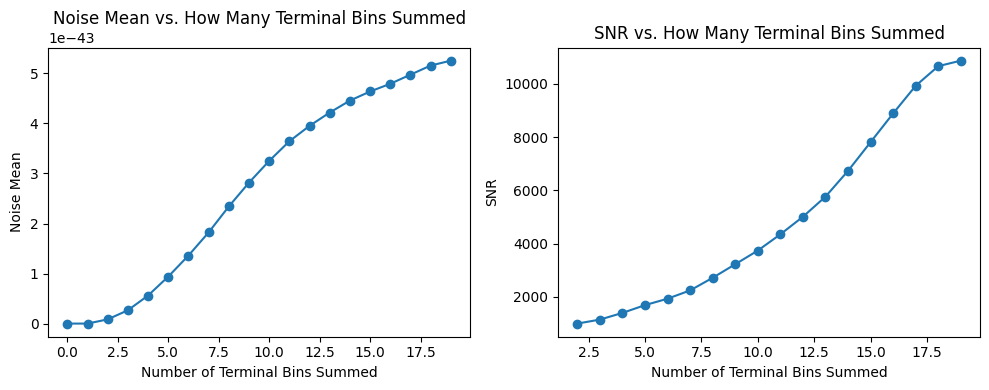

In [4]:
all_noise_variance = []
all_snr_variance = []
for i in range(num_bins):
    window = torch.zeros(num_bins)
    window[-i - 1:] = 1.0
    variance_noise = compute_noise_variance(tof_series_tensor, bin_edges_tensor, window)
    all_noise_variance.append(variance_noise.mean().item())
    signal = NthOrderCenteredMoment(tof_series_tensor, bin_edges_tensor, order=2).forward(window)
    signal_energy = torch.sum(signal ** 2)
    snr_variance = signal_energy / variance_noise
    all_snr_variance.append(snr_variance.mean().item())
all_snr_variance = np.array(all_snr_variance)
all_noise_variance = np.array(all_noise_variance)

plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(all_noise_variance, marker='o')
plt.title("Noise Mean vs. How Many Terminal Bins Summed")
plt.xlabel("Number of Terminal Bins Summed")
plt.ylabel("Noise Mean")
plt.subplot(1, 2, 2)
plt.plot(all_snr_variance, marker='o')
plt.title("SNR vs. How Many Terminal Bins Summed")
plt.xlabel("Number of Terminal Bins Summed")
plt.ylabel("SNR")
plt.tight_layout()
plt.show()